In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Problem Statement

Crowdsourced online content platforms have a constant need to identify the best content in time to appropriately promote and thereby improve the engagement at the website. This challenge involves a similar problem of predicting the upvote count for a queries posted and identify the parameters that affect it the most.

Variable	&nbsp;Definition <br>
ID:	        &nbsp;Question ID <br>
Tag:	    &nbsp;Anonymised tags representing question category <br>
Reputation:	&nbsp;Reputation score of question author <br>
Answers:    &nbsp;Number of times question has been answered <br>
Username:	&nbsp;Anonymised user id of question author <br>
Views:	    &nbsp;Number of times question has been viewed <br>
Upvotes:    &nbsp;(Target) Number of upvotes for the question

In [4]:
#read the data
train=pd.read_csv("train.csv")
train.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330045 entries, 0 to 330044
Data columns (total 7 columns):
ID            330045 non-null int64
Tag           330045 non-null object
Reputation    330045 non-null float64
Answers       330045 non-null float64
Username      330045 non-null int64
Views         330045 non-null float64
Upvotes       330045 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 17.6+ MB


In [6]:
train.describe()

,ID,Reputation,Answers,Username,Views,Upvotes
count,330045.000000,3.300450e+05,330045.000000,330045.000000,3.300450e+05,330045.000000
mean,235748.682789,7.773147e+03,3.917672,81442.888803,2.964507e+04,337.505358
std,136039.418471,2.706141e+04,3.579515,49215.100730,8.095646e+04,3592.441135
min,1.000000,0.000000e+00,0.000000,0.000000,9.000000e+00,0.000000
25%,117909.000000,2.820000e+02,2.000000,39808.000000,2.594000e+03,8.000000
50%,235699.000000,1.236000e+03,3.000000,79010.000000,8.954000e+03,28.000000
75%,353620.000000,5.118000e+03,5.000000,122559.000000,2.687000e+04,107.000000
max,471493.000000,1.042428e+06,76.000000,175738.000000,5.231058e+06,615278.000000


In [9]:
#check missing values
train.isnull().sum()

ID            0
Tag           0
Reputation    0
Answers       0
Username      0
Views         0
Upvotes       0
dtype: int64

###### EDA

Target :Upvotes

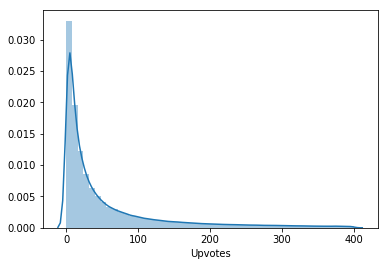

In [16]:
# create the distribution plot of Upvotes
# We filter the Upvotes to remove the extreme values
filt_upvotes=train[train['Upvotes']<=400]['Upvotes']
sns.distplot(filt_upvotes)

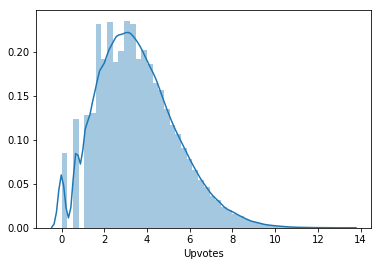

In [32]:
# Our target is right skewed. Lets check if Log transform changes this distribution.
filt_upvotes=np.log1p(train['Upvotes'])
sns.distplot(filt_upvotes)

In [20]:
# Log transform also does give us a somewhat normal distribution of target

In [5]:
def plot_scatter(x,y,data):
    plt.scatter(x=x,y=y,data=data)
    plt.title(x+' vs '+y)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

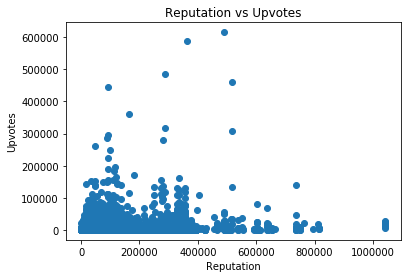

In [27]:
plot_scatter('Reputation','Upvotes',train)

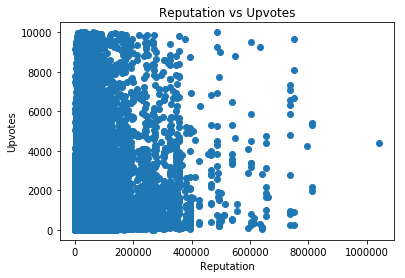

In [33]:
plot_scatter('Reputation','Upvotes',train[train['Upvotes']<=10000])

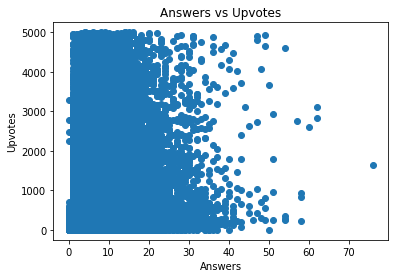

In [39]:
plot_scatter('Answers','Upvotes',train[train['Upvotes']<=5000])

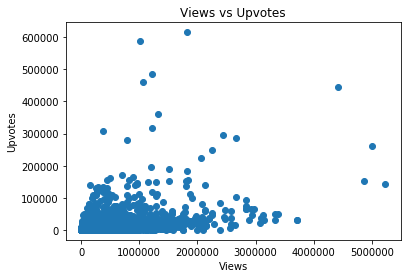

In [38]:
plot_scatter('Views','Upvotes',train)

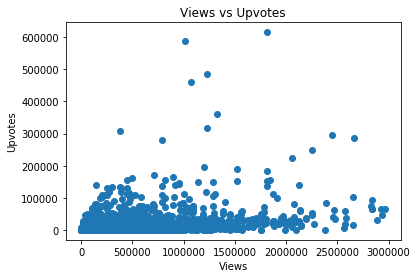

In [14]:
plot_scatter('Views','Upvotes',train[(train['Views']<3000000)])

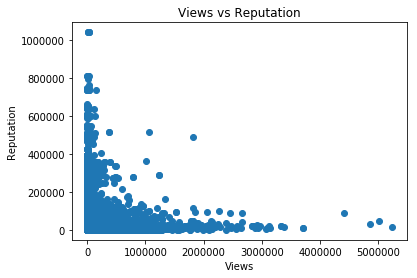

In [6]:
plot_scatter('Views','Reputation',train)

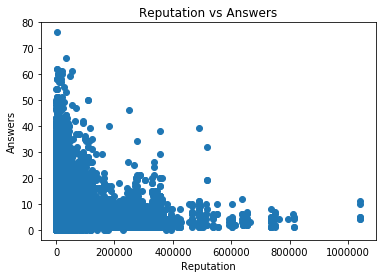

In [8]:
plot_scatter('Reputation','Answers',train)

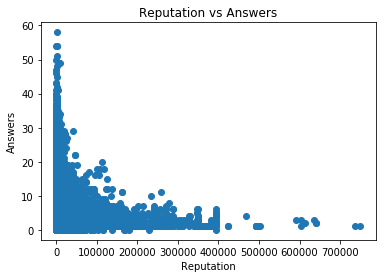

In [5]:
plot_scatter('Reputation','Answers',train[train['Upvotes']<=500])

In [40]:
train.Tag.value_counts()

c    72458
j    72232
p    43407
i    32400
a    31695
s    23323
h    20564
o    14546
r    12442
x     6978
Name: Tag, dtype: int64

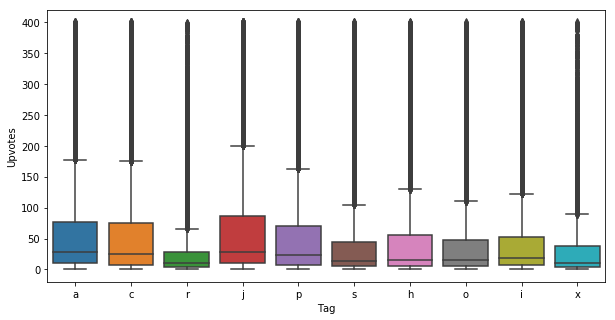

In [9]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Tag',y='Upvotes',data=train[train['Upvotes']<=400])
plt.show()

In [91]:
def map_answers(x):
    if x<=3:
        return '3 or less'
    elif x>3 and x<=5:
        return '3 to 5'
    else:
        return '5 or more'

In [92]:
train['Ans_bucket']=train['Answers'].apply(map_answers)

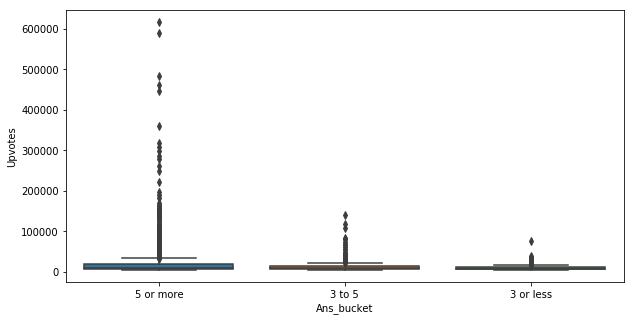

In [93]:
plt.figure(figsize=(10,5))
sns.boxplot(x='Ans_bucket',y='Upvotes',data=train[train['Upvotes']>5000])
plt.show()

In [57]:
train[train['Upvotes']>=500].count()

ID            28389
Tag           28389
Reputation    28389
Answers       28389
Username      28389
Views         28389
Upvotes       28389
Ans_bucket    28389
dtype: int64

In [15]:
# Base Model
# Split data in train and validate

from sklearn.model_selection import train_test_split
X=train.drop(['ID','Upvotes','Username','Tag'],axis=1)
y=train['Upvotes'].values

In [209]:
X=pd.get_dummies(X)

In [16]:
# Some new features
X['Rep_to_Views']=X['Reputation']/X['Views']
X['Views_to_Answers']=X['Views']/X['Answers']

In [17]:
m = X.loc[X['Views_to_Answers'] != np.inf, 'Views_to_Answers'].mean()
X['Views_to_Answers'].replace(np.inf,m,inplace=True)
n = X.loc[X['Rep_to_Views'] != np.inf, 'Rep_to_Views'].mean()
X['Rep_to_Views'].replace(np.inf,n,inplace=True)

In [18]:
X.describe()

,Reputation,Answers,Views,Rep_to_Views,Views_to_Answers
count,3.300450e+05,330045.000000,3.300450e+05,330045.000000,330045.000000
mean,7.773147e+03,3.917672,2.964507e+04,3.753566,6680.637759
std,2.706141e+04,3.579515,8.095646e+04,45.338481,11853.334425
min,0.000000e+00,0.000000,9.000000e+00,0.000000,7.285714
25%,2.820000e+02,2.000000,2.594000e+03,0.022936,1133.000000
50%,1.236000e+03,3.000000,8.954000e+03,0.130340,3170.666667
75%,5.118000e+03,5.000000,2.687000e+04,0.746032,7555.000000
max,1.042428e+06,76.000000,5.231058e+06,10152.888889,799724.000000


In [19]:
X.head()

,Reputation,Answers,Views,Rep_to_Views,Views_to_Answers
0,3942.0,2.0,7855.0,0.501846,3927.500000
1,26046.0,12.0,55801.0,0.466766,4650.083333
2,1358.0,4.0,8067.0,0.168340,2016.750000
3,264.0,3.0,27064.0,0.009755,9021.333333
4,4271.0,4.0,13986.0,0.305377,3496.500000


In [20]:
X_train,X_val,y_train,y_val=train_test_split(
 X, y, test_size=0.3, random_state=48)

In [21]:
y_train[0:10]

array([ 17.,  24., 109., 178.,  11., 266.,   9.,  71.,  39.,  10.])

In [217]:
## Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,make_scorer

In [29]:
## Define RMSE as our scoring function for cross validation
def my_rmse(y_true,y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

In [180]:
## Create a Random Forest Regressor
## Lets use f1 score to find  best number of estimator
rf_reg = RandomForestRegressor(random_state=1,n_estimators=100,max_depth=20,max_features='sqrt',warm_start=False)
min_est=100
max_est=600
score_mean=[]
estimator=[]
score_std_upper=[]
score_std_lower=[]
for est in range(min_est,max_est+1,100):
    rf_reg.set_params(n_estimators=est)
    scores_rfr = cross_val_score(rf_reg,X_train,y_train,cv=5,scoring=make_scorer(my_rmse, greater_is_better=False))
    print('estimators:',est)
#     print('explained variance scores for k=10 fold validation:',scores_rfr)
    print("Est. RMSE score: %f (+/- %f)" % (-1*scores_rfr.mean(), scores_rfr.std() * 2))
    print('')
    score_mean.append(-1*scores_rfr.mean())
    score_std_upper.append(scores_rfr.mean()+scores_rfr.std()*2) # for error plotting
    score_std_lower.append(scores_rfr.mean()-scores_rfr.std()*2) # for error plotting
    estimator.append(est)
    

estimators: 100
Est. RMSE score: 162.539665 (+/- 5.891623)

estimators: 200
Est. RMSE score: 162.119147 (+/- 5.959469)

estimators: 300
Est. RMSE score: 161.918347 (+/- 5.969335)

estimators: 400
Est. RMSE score: 161.774974 (+/- 5.899034)

estimators: 500
Est. RMSE score: 161.773308 (+/- 5.900163)

estimators: 600
Est. RMSE score: 161.785049 (+/- 5.953679)



In [31]:
X_train.shape

(198027, 14)

In [30]:
len(y_train)

132018

In [181]:
# fit the best estimator and check on val data
bst_est=500
rf_reg.set_params(n_estimators=bst_est)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [182]:
rf_reg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

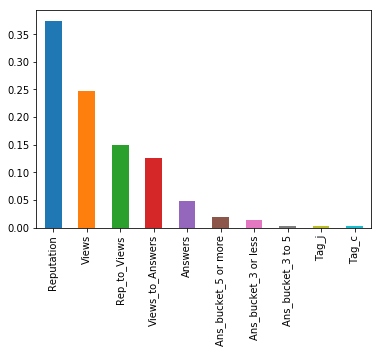

In [183]:
## Plot Feature Importance
## Plot Top 10 Features
feat_importances_xg = pd.Series(rf_reg.feature_importances_, index=X_train.columns)
feat_importances_xg.nlargest(10).plot(kind='bar')

In [184]:
y_val_predict=rf_reg.predict(X_val)

In [185]:
my_rmse(y_val,y_val_predict)

164.39509019686008

In [22]:
## RF is overfitting ond we get worse results on test data.
## Let's try a linear regression model

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [23]:
from sklearn.compose import ColumnTransformer

In [24]:
X_train.columns

Index(['Reputation', 'Answers', 'Views', 'Rep_to_Views', 'Views_to_Answers'], dtype='object')

In [25]:
ct = ColumnTransformer([
        ('Scaling', StandardScaler(), ['Reputation', 'Answers', 'Views','Rep_to_Views', 'Views_to_Answers'])
    ], remainder='passthrough')

X_train_scaled=ct.fit_transform(X_train)

In [26]:
X_val_scaled=ct.transform(X_val)

In [27]:
LR_Model=LinearRegression(normalize=False)
LR_Model.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [30]:
# Val RMSE
y_val_predict=LR_Model.predict(X_val_scaled)
my_rmse(y_val,y_val_predict)

3944.247464661982

In [31]:
# Train RMSE
y_train_predict=LR_Model.predict(X_train_scaled)
my_rmse(y_train,y_train_predict)

2596.4098459108504

In [32]:
LR_Model.coef_

array([ 924.74581141, -240.82363871, 1795.61078844, -276.47093398,
       -492.09321385])

In [255]:
## Predict on Test data for first submission:

test=pd.read_csv("test.csv")

In [256]:
test['Ans_bucket']=test['Answers'].apply(map_answers)

In [257]:
# Some new features
test['Rep_to_Views']=test['Reputation']/test['Views']
test['Views_to_Answers']=test['Views']/test['Answers']

In [258]:
m = test.loc[test['Views_to_Answers'] != np.inf, 'Views_to_Answers'].mean()
test['Views_to_Answers'].replace(np.inf,m,inplace=True)
n = test.loc[test['Rep_to_Views'] != np.inf, 'Rep_to_Views'].mean()
test['Rep_to_Views'].replace(np.inf,n,inplace=True)

In [259]:
test.columns

Index(['ID', 'Tag', 'Reputation', 'Answers', 'Username', 'Views', 'Ans_bucket',
       'Rep_to_Views', 'Views_to_Answers'],
      dtype='object')

In [260]:
ID=test.ID
test=test.drop(['ID','Username'],axis=1)
test=pd.get_dummies(test)

In [261]:
test_scaled=ct.transform(test)

In [262]:
#y_test_predict=rf_reg.predict(test) ## RF Model
y_test_predict=LR_Model.predict(test_scaled) ## Linear Reg Model

In [263]:
sub_df=pd.DataFrame(y_test_predict,columns=['Upvotes'])
sub_df['ID']=ID
sub_df=sub_df[['ID','Upvotes']]

In [264]:
sub_df.to_csv('Eighth_sub.csv',index=False)

In [265]:
y_test_predict[:10]

array([-1.09518684e+14,  2.79248870e+13, -2.09471490e+14,  1.95725729e+12,
       -2.41296631e+13, -2.28442861e+13, -9.69018980e+13, -1.10420666e+14,
       -5.45893299e+13,  2.03958606e+13])

In [266]:
sub_df.head()

,ID,Upvotes
0,366953,-1.095187e+14
1,71864,2.792489e+13
2,141692,-2.094715e+14
3,316833,1.957257e+12
4,440445,-2.412966e+13


In [194]:
test.head()

,Reputation,Answers,Views,Rep_to_Views,Views_to_Answers,Tag_a,Tag_c,Tag_h,Tag_i,Tag_j,Tag_o,Tag_p,Tag_r,Tag_s,Tag_x,Ans_bucket_3 or less,Ans_bucket_3 to 5,Ans_bucket_5 or more
0,5645.0,3.0,33200.0,0.170030,11066.666667,1,0,0,0,0,0,0,0,0,0,1,0,0
1,24511.0,6.0,2730.0,8.978388,455.000000,0,1,0,0,0,0,0,0,0,0,0,0,1
2,927.0,1.0,21167.0,0.043795,21167.000000,0,0,0,1,0,0,0,0,0,0,1,0,0
3,21.0,6.0,18528.0,0.001133,3088.000000,0,0,0,1,0,0,0,0,0,0,0,0,1
4,4475.0,10.0,57240.0,0.078180,5724.000000,0,0,0,1,0,0,0,0,0,0,0,0,1


###### Lets Fit Polynomial Regression